![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 



import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import re 
import time
import datetime
from datetime import datetime, timedelta

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [9]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [10]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [12]:
data.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0


In [13]:
data.URL_TA[6]

'/Restaurant_Review-g189158-d8758873-Reviews-Lisboa_City-Lisbon_Lisbon_District_Central_Portugal.html'

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [14]:
# Для примера я возьму столбец Number of Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [15]:
data['Number_of_Reviews_isNAN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Number_of_Reviews_isNAN, Length: 50000, dtype: uint8

In [16]:
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
data['Number of Reviews'].fillna(0, inplace=True)

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [17]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
dtype: int64

In [18]:
data['scity']=data['City']

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [19]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
#data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

In [20]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,scity
48672,id_4861,London,"['Cafe', 'Italian', 'British', 'Vegetarian Fri...",4870.0,$,31.0,"[['Just a lunch', 'Excellent for breakfast!'],...",/Restaurant_Review-g186338-d4080516-Reviews-As...,d4080516,1,4.5,0,London
26454,id_4071,Paris,['French'],4072.0,$,61.0,"[['As good as always - nothing changes', 'Grea...",/Restaurant_Review-g187147-d4432685-Reviews-Le...,d4432685,1,4.5,0,Paris
32552,id_104,Vienna,"['Austrian', 'Vegetarian Friendly', 'Gluten Fr...",105.0,$$ - $$$,1852.0,"[['Old Restaurant in Fleischmarkt', 'Great foo...",/Restaurant_Review-g190454-d1011415-Reviews-Gr...,d1011415,1,4.0,0,Vienna
35783,id_281,Prague,"['Czech', 'Cafe', 'European', 'Vegetarian Frie...",282.0,$,65.0,"[['Good coffee close to Letna', 'Favorite Cafe...",/Restaurant_Review-g274707-d9565372-Reviews-Ca...,d9565372,1,4.5,0,Prague
16484,id_2738,Vienna,NaN,2740.0,NaN,0.0,"[[], []]",/Restaurant_Review-g190454-d8773673-Reviews-Do...,d8773673,1,4.0,1,Vienna


#### Возьмем следующий признак "Price Range".

In [21]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [22]:
# Ваша обработка 'Price Range'
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,scity
15137,id_3236,Barcelona,"['Sushi', 'Asian']",3237.0,$$ - $$$,38.0,"[['Very good and fast', 'Average'], ['12/10/20...",/Restaurant_Review-g187497-d5862836-Reviews-Kw...,d5862836,1,4.0,0,Barcelona
26450,id_788,London,"['Italian', 'Cafe', 'Mediterranean', 'European...",789.0,$$ - $$$,262.0,"[['Amazing food!', 'Good for breakfast & Lunch...",/Restaurant_Review-g186338-d7053176-Reviews-Br...,d7053176,1,4.5,0,London
16891,id_15893,London,['British'],15905.0,$$ - $$$,2.0,"[['Maria Turner', 'Good Pub'], ['10/19/2017', ...",/Restaurant_Review-g186338-d12547345-Reviews-P...,d12547345,1,5.0,0,London
26500,id_660,Hamburg,"['Cafe', 'German', 'European', 'Vegetarian Fri...",661.0,$,48.0,"[['Excellent coffee, good service', 'Disappoin...",/Restaurant_Review-g187331-d1039143-Reviews-Ca...,d1039143,1,4.0,0,Hamburg
43465,id_9634,London,"['Chinese', 'Indian', 'Asian', 'Halal']",9643.0,$$ - $$$,143.0,"[['Not worth it', ""Friend's birthday at Maida""...",/Restaurant_Review-g186338-d953616-Reviews-Mai...,d953616,1,3.5,0,London


> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

In [23]:
# тут ваш код на обработку других признаков
# .....

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

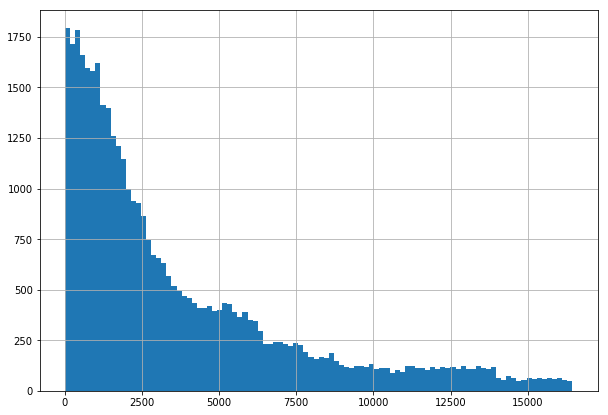

In [24]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

In [25]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,scity
5050,id_5050,Zurich,"['Swiss', 'European', 'Central European']",898.0,$$ - $$$,56.0,"[['A good place for a quick lunch', 'Smoking a...",/Restaurant_Review-g188113-d1817085-Reviews-Ho...,d1817085,0,0.0,0,Zurich
28241,id_1090,Hamburg,"['Pizza', 'Turkish']",1092.0,NaN,6.0,"[['Very tasty pizza and pasta', 'Delicious and...",/Restaurant_Review-g187331-d7033551-Reviews-Pi...,d7033551,1,5.0,0,Hamburg
17878,id_2984,Brussels,NaN,2985.0,NaN,85.0,"[['Total Rip Off!!', 'Rip Off Scam! Stay Away!...",/Restaurant_Review-g188644-d946743-Reviews-Au_...,d946743,1,1.5,0,Brussels
14782,id_700,Geneva,"['French', 'Soups']",703.0,NaN,6.0,"[['Light meal or juice'], ['04/10/2017']]",/Restaurant_Review-g188057-d8139611-Reviews-En...,d8139611,1,4.5,0,Geneva
12456,id_13865,Paris,NaN,13867.0,NaN,26.0,"[['Good food, good price'], ['09/28/2016']]",/Restaurant_Review-g187147-d10140372-Reviews-N...,d10140372,1,1.5,0,Paris


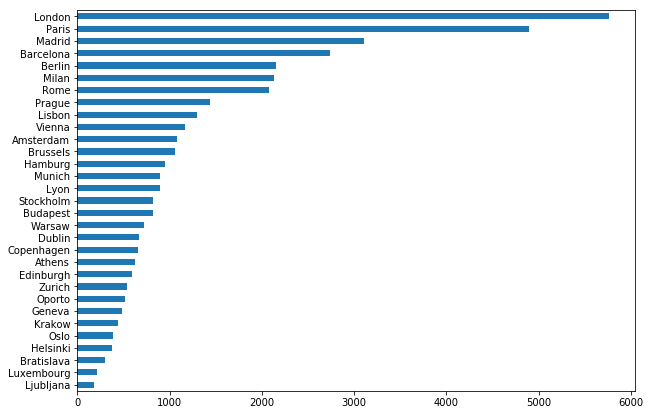

In [26]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

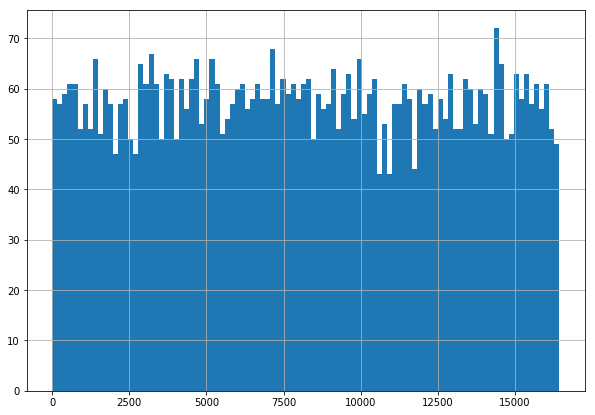

In [27]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

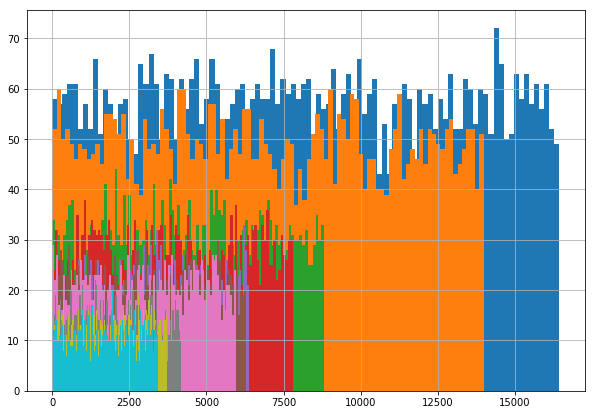

In [28]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


Можно создать признак показывающий относительный размер города, а так же отнормировать ранг относитеьно города(размера)

In [29]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,scity
8162,id_8162,Paris,NaN,8508.0,NaN,17.0,"[['Médiocre', ""Loved Momen'Tea!""], ['11/06/201...",/Restaurant_Review-g187147-d11733790-Reviews-M...,d11733790,0,0.0,0,Paris
46624,id_2862,Berlin,['European'],2864.0,NaN,2.0,"[['Great place for a night out in Berlin'], ['...",/Restaurant_Review-g187323-d12925533-Reviews-B...,d12925533,1,5.0,0,Berlin
5062,id_5062,Amsterdam,"['European', 'Dutch', 'Vegetarian Friendly', '...",1190.0,$$ - $$$,62.0,"[['Little gem, Off the beaten track', 'Perfect...",/Restaurant_Review-g188590-d3676397-Reviews-Va...,d3676397,0,0.0,0,Amsterdam
32295,id_1728,Berlin,NaN,1730.0,NaN,11.0,"[['Cereal-iously good', 'Killer cereal!!'], ['...",/Restaurant_Review-g187323-d12161521-Reviews-F...,d12161521,1,4.5,0,Berlin
29350,id_830,Copenhagen,"['Italian', 'European', 'Pizza']",831.0,$$ - $$$,55.0,"[['3 good,start with food, service, price', 'A...",/Restaurant_Review-g189541-d4275093-Reviews-Re...,d4275093,1,4.0,0,Copenhagen


In [30]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,scity
39936,id_2291,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",2293.0,$,96.0,"[['Tasty', 'Disappointing food'], ['05/13/2016...",/Restaurant_Review-g187849-d2441920-Reviews-Ro...,d2441920,1,4.0,0,Milan
28877,id_6769,Paris,"['French', 'American']",6770.0,$$ - $$$,86.0,"[['Alternative bar for drinks', 'Great place f...",/Restaurant_Review-g187147-d3187248-Reviews-3_...,d3187248,1,3.5,0,Paris
29108,id_5790,Paris,"['French', 'European']",5791.0,$$ - $$$,111.0,"[['Cute casual cafe!', 'Quiet place for lunch'...",/Restaurant_Review-g187147-d2692744-Reviews-Au...,d2692744,1,3.5,0,Paris
15511,id_5046,Barcelona,NaN,5047.0,NaN,26.0,"[['Poor service, acceptable bakes', 'Try the p...",/Restaurant_Review-g187497-d8017782-Reviews-Fo...,d8017782,1,4.0,0,Barcelona
21678,id_4347,Barcelona,['International'],4348.0,$$ - $$$,0.0,"[[], []]",/Restaurant_Review-g187497-d2061142-Reviews-Ka...,d2061142,1,5.0,1,Barcelona


### Посмотрим распределение целевой переменной

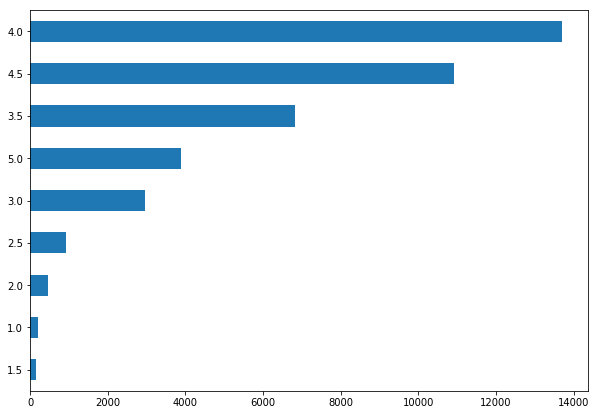

In [31]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

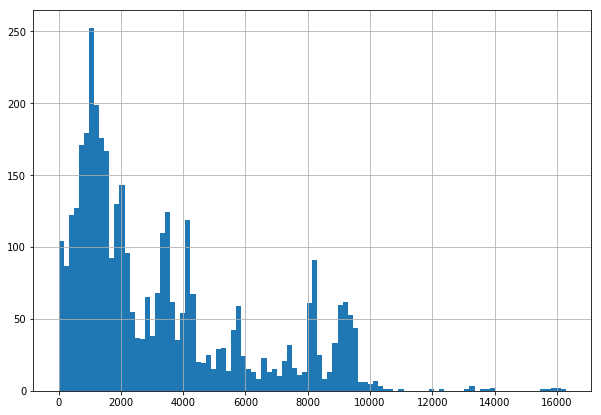

In [32]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

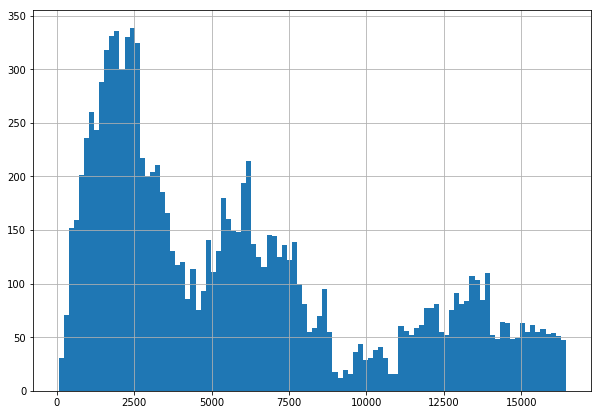

In [33]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

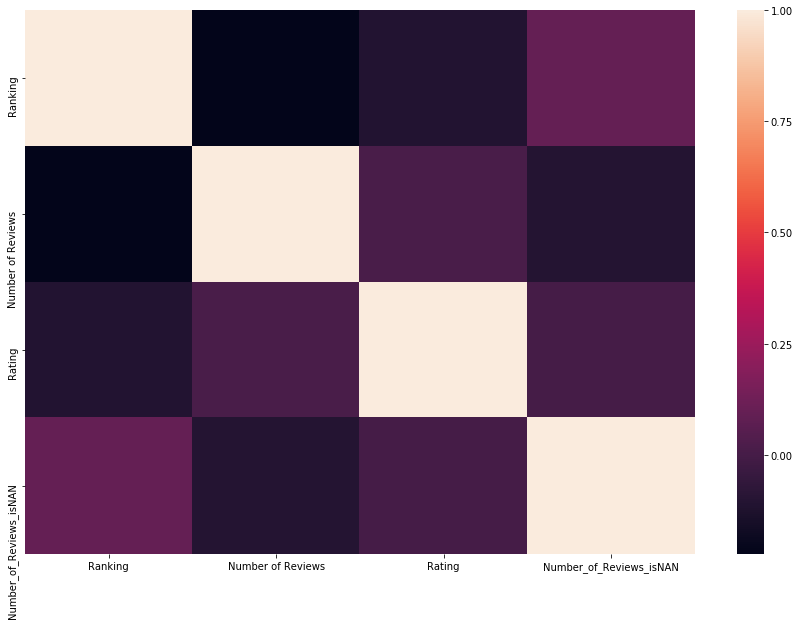

In [34]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

In [35]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,scity
23938,id_10093,London,NaN,10102.0,NaN,4.0,[['This Restaurant has been sold and has ceas....,/Restaurant_Review-g186338-d11703089-Reviews-S...,d11703089,1,4.5,0,London
48469,id_784,Helsinki,NaN,785.0,NaN,5.0,"[['Fastfood with taste', 'Closed? Not that I k...",/Restaurant_Review-g189934-d814224-Reviews-Sop...,d814224,1,4.0,0,Helsinki
28262,id_1065,Prague,['Fast Food'],1066.0,$,50.0,"[['Good, but not many vegetarian options', 'Ta...",/Restaurant_Review-g274707-d7383725-Reviews-Ba...,d7383725,1,4.0,0,Prague
4302,id_4302,Paris,"['Lebanese', 'Mediterranean']",9320.0,NaN,2.0,"[['Excellent'], ['09/23/2008']]",/Restaurant_Review-g187147-d786628-Reviews-Kan...,d786628,0,0.0,0,Paris
30606,id_3261,Paris,['Spanish'],3262.0,$$ - $$$,98.0,"[['Superb restaurant', 'good but expensive'], ...",/Restaurant_Review-g187147-d4261032-Reviews-Ch...,d4261032,1,4.0,0,Paris


# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [36]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [37]:
##########
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')
data['Number of Reviews'].fillna(0, inplace=True)


In [38]:
###### добавим относительный размер города основываясь на максимальном рейтинге в каждом городе
gk=data.groupby('City')  
ss=gk.Ranking.max()
def rrr(nam):
    return ss[nam]

data['rcity']=data['City'].apply(lambda x: rrr(x))

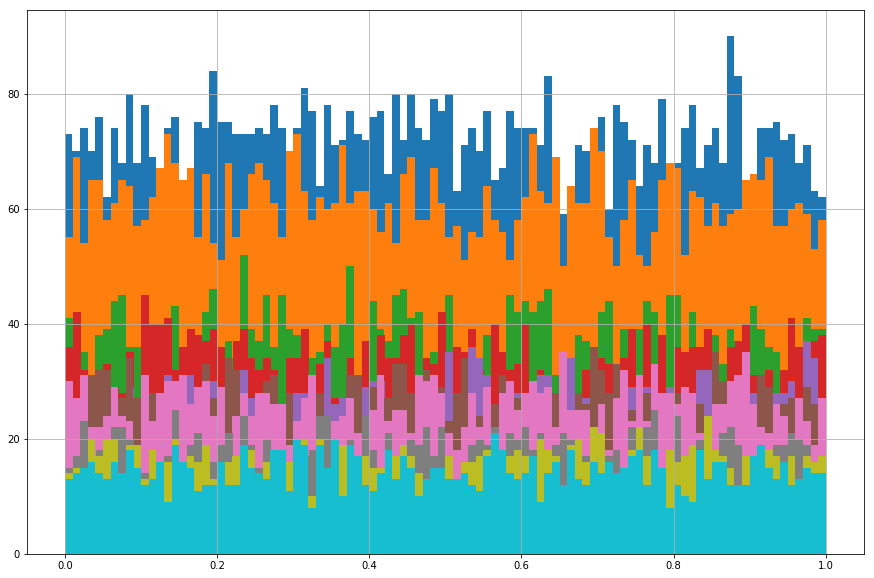

In [39]:
# отнормируем ранги относително города
data['normrank'] = data['Ranking']/data['rcity']

# посмотрим на топ 10 городов
for x in (data['City'].value_counts())[0:10].index:
    data['normrank'][data['City'] == x].hist(bins=100)
plt.show()
 

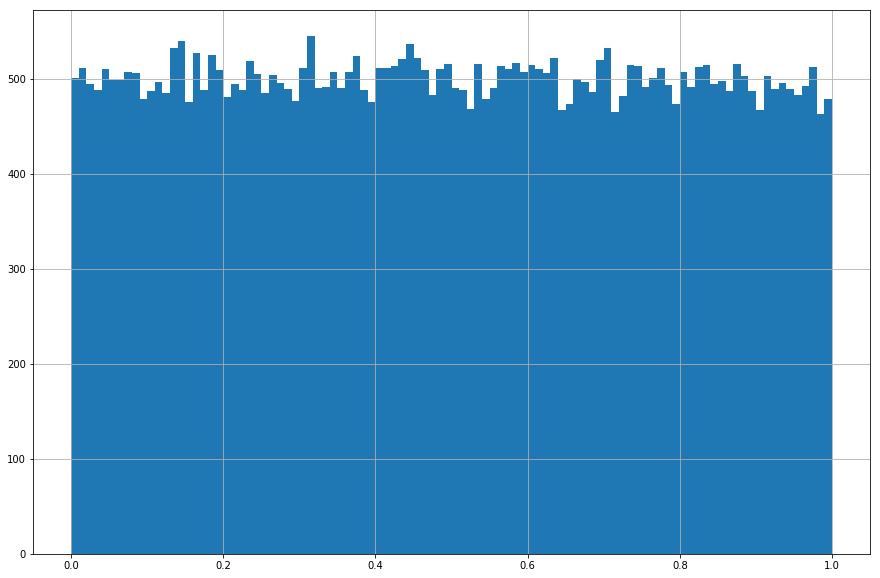

In [40]:
#и на ранг в целом
data['normrank'].hist(bins=100)
#ранг стал равномерным во всем сете

In [41]:
#преобразуем данные сосписком кухонь из строки в список
data.rename(columns={'Cuisine Style': 'CuisineStyle'}, inplace=True) 
data.CuisineStyle = data.CuisineStyle.apply(lambda x: str(x).replace(
    '[', '').replace(']', '').replace('\'', '').replace(' ', '').split(','))

In [42]:
CuisineStyle = data['CuisineStyle'].tolist()
#создадим множество всех тпов кухонь
Cuisine = set()  # создаём пустое множество для хранения уникальных значений 
for i in CuisineStyle:  # начинаем перебор
    for j in i:
        Cuisine.add(j) # добавляем название типа кухни к множеству

# добавим столбец  количества типов кухонь
data['CuisineLen'] = data.CuisineStyle.apply(lambda x: len(x))
data['CuisineStyle'][0][0]

'Bar'

In [43]:
####### добавим признаки соответсвующие каждой кухне
def find_item(cell):
    if item in cell:
        return 1
    return 0
#dm = pd.DataFrame()
for item in Cuisine:
    data[item] = data['CuisineStyle'].apply(find_item)
data.head(2)

,Restaurant_id,City,CuisineStyle,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Steakhouse,French,NativeAmerican,VeganOptions,Vietnamese,MiddleEastern,Contemporary,CentralAsian,Filipino,Mongolian
0,id_0,Paris,"[Bar, Pub]",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,0,0,0,0,0,0,0,0,0,0
1,id_1,Helsinki,"[European, Scandinavian, GlutenFreeOptions, Ve...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,0,0,0,1,0,0,0,0,0,0


In [44]:
#заполним nan
data['Reviews'].fillna('[], []', inplace=True)

In [45]:
# выделим каждый одзыв е его дату в отдельные столбцы

data['Review'] = data.Reviews.apply(lambda x: str(x).split('],')[0])
data['date'] = data.Reviews.apply(lambda x: str(x).split('],')[1])
data['Review1'] = data.Review.apply(lambda x: str(x).split('\',')[0] if len(x) > 2 else '')
data['Review2'] = data.Review.apply(lambda x: str(x).split('\',')[1] if len(str(x).split('\',')) > 1 else '')
data['date1'] = data.date.apply(lambda x: str(x).split('\',')[0] if len(x) > 4 else '')
data['date2'] = data.date.apply(lambda x: str(x).split('\',')[1] if len(str(x).split('\',')) > 1 else '')
data = data.drop(['Review', 'date'], axis=1)  # удалим лишние столбцы
data['Review1'] = data['Review1'].apply(lambda x: str(x).replace(
    '[', '').replace(']', '').replace('\'', ''))
data['Review2'] = data['Review2'].apply(lambda x: str(x).replace(
    '[', '').replace(']', '').replace('\'', ''))
data['date1'] = data['date1'].apply(lambda x: str(x).replace(
    '[', '').replace(']', '').replace('\'', '').replace(' ', ''))
data['date2'] = data['date2'].apply(lambda x: str(x).replace(
    '[', '').replace(']', '').replace('\'', '').replace(' ', ''))


In [46]:
#посчитаем количество слов в отзывах
#data['lenReview1']=data['Review1'].apply(lambda x: len(x.split(' ')) if x!='' else 0)
#data['lenReview2']=data['Review2'].apply(lambda x: len(x.split(' ')) if x!='' else 0)

#модель ухудшилась

In [47]:
#попробуем количество ! в отзывах

data['lenReview1'] = data['Review1'].apply(lambda x: x.count('!'))
data['lenReview2'] = data['Review2'].apply(lambda x: x.count('!'))

In [48]:
#результат лучше если учитывать сумму а не два отдельных признака
data['lenW']=data['lenReview1']+data['lenReview2']
data= data.drop(['lenReview1','lenReview2'], axis = 1) #удалим лишние столбцы


In [49]:
#посчитаем длинну отзывов
#data['lenReview1'] = data['Review1'].apply(lambda x: len(x))
#data['lenReview2'] = data['Review2'].apply(lambda x: len(x))
#результат хуже

In [50]:
def ddd(x,y):
    if x !=''and y !='':
        return 2
    else:
        if x !=''or y !='':
            return 1
        else:
            return 0    
# посчитаем количество опубликованых отзывов чтобы учесть их если в столбце Number of Reviews стоит  0
data['countt'] = data.apply(lambda x: ddd(x.Review1, x.Review2),axis=1)

In [51]:
def ddd2(x,y):
    if x == 0:
        return y
    else:
        return x

 #если отзывы все таки есть учтем их
data.rename(columns={'Number of Reviews': 'Number_of_Reviews'}, inplace=True)
data['countt'] = data['countt'].apply(lambda x: float(x))
data['Number_of_Reviews'] =data.apply(lambda x: ddd2(x.Number_of_Reviews, x.countt), axis=1)
data = data.drop(['countt'], axis = 1) #удалим лишние столбцы

In [52]:
#pattern = re.compile('\d+/\d+/\d+')
#data['date1o']= data['date1'].apply(lambda x: pattern.search(x))
#data[data['date1o'].isna()==True]

In [53]:
# заполним пропуски в датах
data['date1'] = data['date1'].apply(lambda x: x if x!='' else '01/01/2985' ) 
data['date2'] = data['date2'].apply(lambda x: x if x!='' else '01/01/2970' ) 

data['date1'][38330]='01/01/2985' # одна строка в датасете имеет некорректную дату

#переведем даты в формат datetime
data['date1']= data['date1'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y' ))
data['date2']= data['date2'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y' ))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [54]:
#добавим столбец с разницей в днях между двумя последними отзывами. пустые значения заменим средним 142
#максимальная разница в днях 3207.0 примерно 9 лет

data['days']=data['date1']-data['date2']

In [55]:
data['days'].max()    #все что больше 5479 нет одной или двух дат  = пустые значения заменим 
data['days'] = data['days'].apply(lambda x: x.days if x.days < 5400 and x.days > 0   else 3297)  
#mean - 145.98557721320378  median - 66.0   max - 3296
# заменим пустые на максимальное значение

In [56]:
#добавим признак показывающий что этих данных не было в сете
data['days_is_nan'] = data['days'].apply(lambda x: 0 if x<3297 else 1)

Лучший результат если заменить пропуски на максимальное количество деней. Можно предположить что пропущенные данные это худший вариант.

In [57]:
data[data['days']>0]['days'].max()

3297

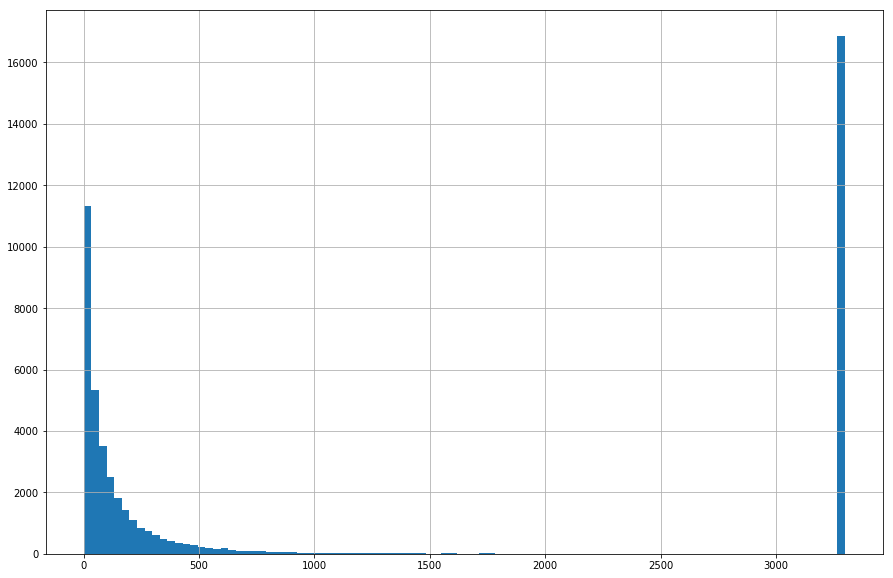

In [58]:
data[data['days']>0]['days'].hist(bins=100)

In [59]:
#data['days']=data['days']**(1/3)
#data[data['days']>0]['days'].hist(bins=100)

In [60]:
#добавим столбец с временем до последнего отзыва
def ddd3(x,y):
    if x > y:
        return x
    else:
        return y
# поместим в date1 старшую дату
data['date1'] = data.apply(lambda x: ddd3(x.date1, x.date2), axis=1)
data['days2'] = datetime(2020, 9, 9, 0, 0)-data['date1'] #09.09.2020


In [61]:
#добавим признак указывающий на отсутсвие данных 
#и замним строки в которых не было данных
#data['days2_is_nan'] = data['days2'].apply(lambda x: 0 if x.days > 0   else 1) #ухудшает модель
data['days2'] = data['days2'].apply(lambda x: x.days if x.days > 0   else 1061) #max =4538 mean =1159.516420383925median=1062.0


лучший вариант если пропущенные данные заменить медианой

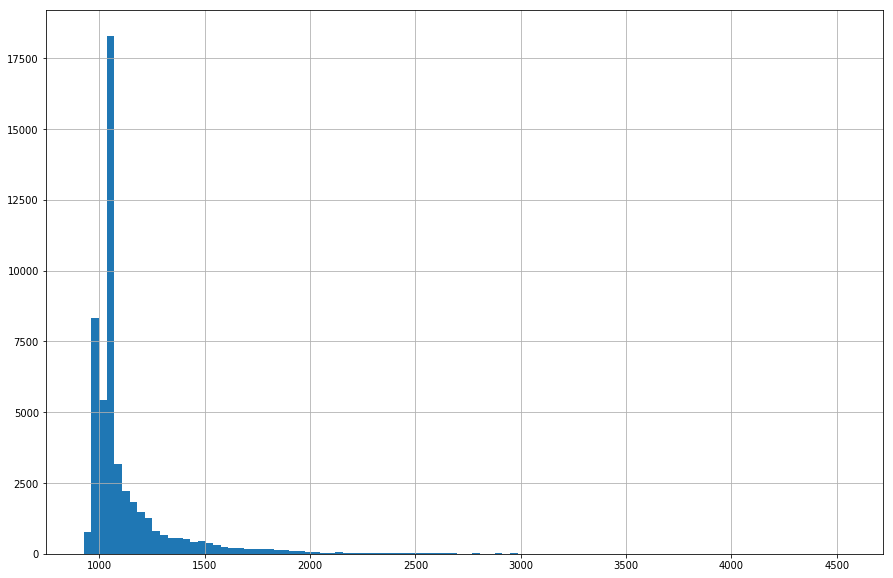

In [62]:
data[data['days2']>0]['days2'].hist(bins=100)

In [63]:
data[data['days2']>0]['days2'].mean()

1132.33574

In [64]:
data['Price Range'].fillna('0', inplace=True)
data['Price Range'].value_counts()

#посмотрим на распределение цен
def get_boxplot(column,score):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y=score, 
                data=data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()  
# заменим значения
def prrepl(stri):
    if stri =='$':
        return 1
    else:
        if stri =='$$ - $$$':
            return 2
        else:
            if stri =='$$$$':
                return 3
            else:
                return 0               
            
data['Price Range'] = data['Price Range'].apply(prrepl)

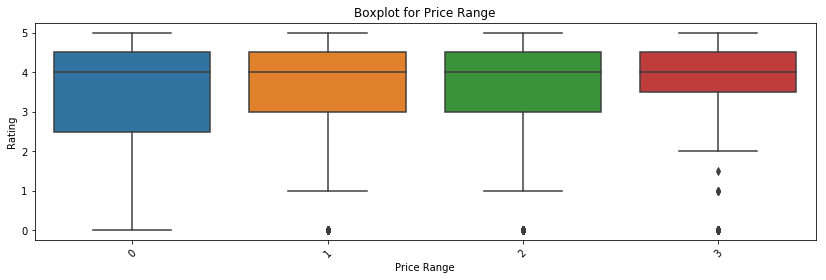

In [65]:
get_boxplot('Price Range','Rating') #MAE: 0.204844375


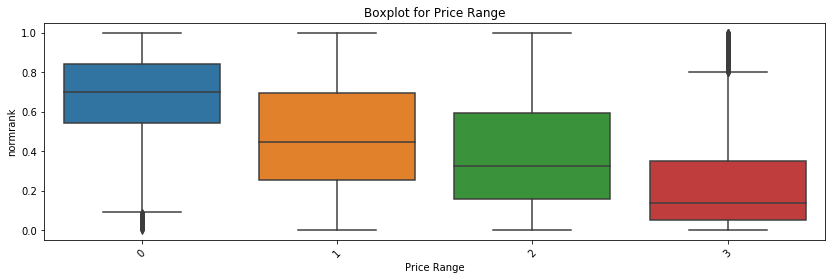

In [66]:
get_boxplot('Price Range','normrank')

In [67]:
#добавим признак выделяющий отсутсвующие данные
#data['Price_Range_nan'] = data['Price Range'].apply(lambda x: 1 if x==0 else 0)
#ухудшает модель

Пропущенных данных очень много и нельзя сказать однозначно что они пренадлежат какому то из существующих множеств.
Скорее всего будет необходимо выделить их в отделюную категорию.

Лучший результат если не использовать думмми переменную по признаку Price Range вообще. Проверил если поместить пропуски в нижнюю категорию = 0,
верхнюю категорию = 4, в седианное значение = 2. Лучший результат при добавлении отдельную нижнюю категорию 

Попробуем добавить внешние данные. Признак столицы, население городов, площади, бюджеты стран в которых расположен городо.

In [68]:
inp ={}
cc = data['City'].value_counts().index.tolist()
inp[cc[0]]=[1,8908081, 1572, 716584]
inp[cc[1]]=[1,2148327, 105.4, 357749]
inp[cc[2]]=[1,3266126, 607, 492400]
inp[cc[3]]=[0,1636762, 101.3, 492400]
inp[cc[4]]=[1,3644826, 891.68, 397000]
inp[cc[5]]=[0,1378689, 181.67, 884400]
inp[cc[6]]=[1,2870500, 1287.36, 884400]
inp[cc[7]]=[1,1301132, 500, 83620]
inp[cc[8]]=[1,505526, 100.05, 92990]
inp[cc[9]]=[1,1897491 , 414.7, 461000]
inp[cc[10]]=[1,872757 , 219.4, 344800]
inp[cc[11]]=[1,179277 , 32.61, 248700]
inp[cc[12]]=[0,1841179 , 755.09, 397000]
inp[cc[13]]=[0,1471508 , 310.71, 397000]
inp[cc[14]]=[0,506615 , 47.87, 357749]

inp[cc[15]]=[1,961609 , 188, 274800]
inp[cc[16]]=[1,1752286 , 525.14 , 63630]
inp[cc[17]]=[1,1790658 , 517 , 90800]
inp[cc[18]]=[1,1173179 , 115 , 85410]
inp[cc[19]]=[1,615993 , 86.40 , 173500]
inp[cc[20]]=[1,664046 , 412 , 95360]
inp[cc[21]]=[1,488100 , 118 ,  237618]
inp[cc[22]]=[0,428737 ,  91.88 ,  223500]
inp[cc[23]]=[0,237591 ,  41.66,  92990]
inp[cc[24]]=[0,200548 ,  15.93,  223500]
inp[cc[25]]=[0,769498 ,  327,  90800]
inp[cc[26]]=[1,673469 ,  454,  214300]
inp[cc[27]]=[1,655281,  715.48,  136800]
inp[cc[28]]=[1,437725,  368,  37090]
inp[cc[29]]=[1,115227,  51.47,  27600]
inp[cc[30]]=[1,284355,  163.8,  20200]
inp[cc[30]][0]

1

In [69]:
#добавим признак столицы
def add_stol(city):
    return inp[city][0]
    
data['is_stol']=data['City'].apply(lambda x: add_stol(x))

#население
def add_dem(city):
    return inp[city][1]
    
data['dem']=data['City'].apply(lambda x: add_dem(x))

#площадь
def add_S(city):
    return inp[city][2]
    
data['S']=data['City'].apply(lambda x: add_S(x))

#бюджеты

def add_bu(city):
    return inp[city][3]
    
data['bu']=data['City'].apply(lambda x: add_bu(x))

прирост незначительный
попробуем добавить плотность населения

In [70]:
data['plotn'] = data['dem']/data['S']

посчитаем сколько ресторанов в каждом городе учавствует в датасете

In [71]:
kols = data['City'].value_counts().values
#преабразуем в словарь
kk={}
for i in range(0,31):
    kk[cc[i]] = kols[i]
    
    
#добавим как признак
def add_kols(city):
    return kk[city]
    
data['kols']=data['City'].apply(lambda x: add_kols(x))


прирост незначительный, посмотрим сколько человек приходится на ресторан

In [72]:
#data['kols']=data['dem']/data['kols'] результат хуже

может быть id в рейтинге TripAdvisor не случайная величина...

In [73]:
data['Idea'] = data['ID_TA'].apply(lambda x: float(x[1:]))



Как ни странно это дало результат
проверим то же для id ресторана

In [74]:
#data['Idea2'] = data['Restaurant_id'].apply(lambda x: float(x[3:])) 
#результата почти нет, не будем его использовать


,Rating,Ranking,Price Range,Number_of_Reviews,rcity,normrank,CuisineLen,lenW,days,days2,dem,S,bu,plotn,kols,Idea,sample
Rating,1.000000,-0.109897,0.015052,0.011011,-0.014849,-0.168783,0.034506,0.026496,-0.018638,-0.024618,-0.004918,0.009214,-0.008560,-0.014405,-0.014779,0.049589,0.936543
Ranking,-0.109897,1.000000,-0.244280,-0.223156,0.709068,0.570506,-0.322408,-0.049664,0.153333,0.143327,0.567986,0.375697,0.389803,0.325236,0.709012,0.049756,0.006271
Price Range,0.015052,-0.244280,1.000000,0.312827,0.046516,-0.482829,0.563037,0.070313,-0.423323,-0.121097,0.034858,0.024478,0.022905,0.032727,0.047093,-0.289650,-0.001212
Number_of_Reviews,0.011011,-0.223156,0.312827,1.000000,0.025882,-0.407404,0.409403,0.042826,-0.209009,-0.149111,0.023260,0.047590,0.092650,-0.007203,0.026251,-0.289950,0.002689
rcity,-0.014849,0.709068,0.046516,0.025882,1.000000,-0.003133,-0.024780,0.009739,-0.070057,-0.001733,0.799645,0.527513,0.549610,0.460680,0.999949,-0.057841,0.004591
normrank,-0.168783,0.570506,-0.482829,-0.407404,-0.003133,1.000000,-0.543578,-0.105676,0.381625,0.243517,-0.001172,0.000692,-0.002906,-0.003700,-0.003148,0.167943,0.001995
CuisineLen,0.034506,-0.322408,0.563037,0.409403,-0.024780,-0.543578,1.000000,0.068919,-0.369577,-0.218419,0.047455,0.078676,0.018136,-0.099120,-0.024105,-0.220469,-0.003202
lenW,0.026496,-0.049664,0.070313,0.042826,0.009739,-0.105676,0.068919,1.000000,-0.148249,0.035381,0.011588,0.013180,0.006405,0.003207,0.009877,-0.012389,0.004501
days,-0.018638,0.153333,-0.423323,-0.209009,-0.070057,0.381625,-0.369577,-0.148249,1.000000,-0.180573,-0.130032,-0.114985,0.019886,0.042987,-0.070960,0.271078,-0.002919
days2,-0.024618,0.143327,-0.121097,-0.149111,-0.001733,0.243517,-0.218419,0.035381,-0.180573,1.000000,-0.020963,-0.022118,-0.014987,0.027259,-0.001960,-0.147621,-0.001079


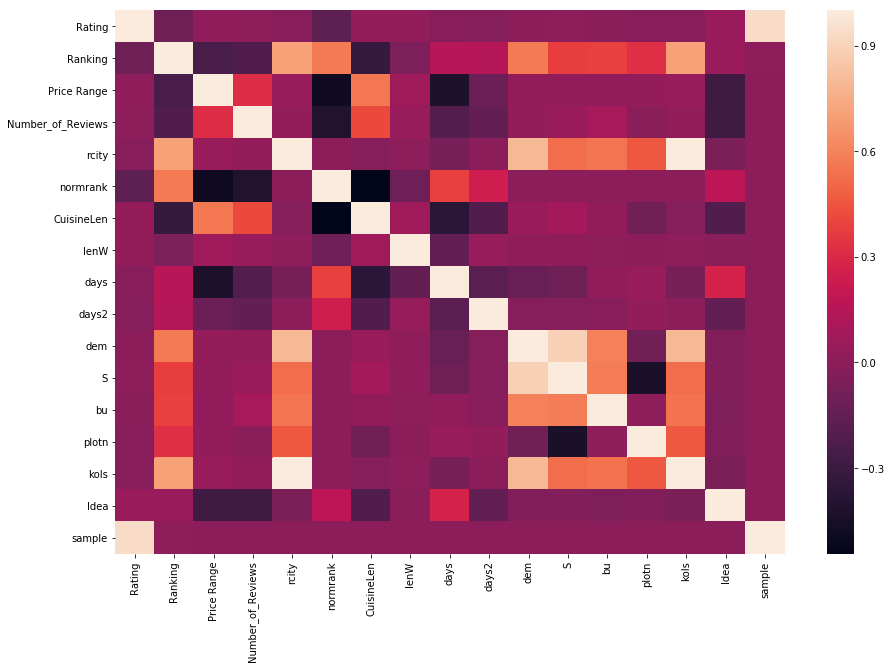

In [75]:
cdata=pd.DataFrame()
cdata['Rating']=data['Rating']
cdata['Ranking']=data['Ranking']
cdata['Price Range']=data['Price Range']
cdata['Number_of_Reviews']=data['Number_of_Reviews']
cdata['rcity']=data['rcity']
cdata['normrank']=data['normrank']
cdata['CuisineLen']=data['CuisineLen']
cdata['lenW']=data['lenW']
cdata['days']=data['days']
cdata['days2']=data['days2']
cdata['dem']=data['dem']
cdata['S']=data['S']
cdata['bu']=data['bu']
cdata['plotn']=data['plotn']
cdata['kols']=data['kols']   
cdata['Idea']=data['Idea']                        
cdata['sample']=data['sample']   

plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(cdata.corr(),)
cdata.corr()


параметр kols очень сильно корелирует с rcity один можно удалить (почти не повлияло на результат)

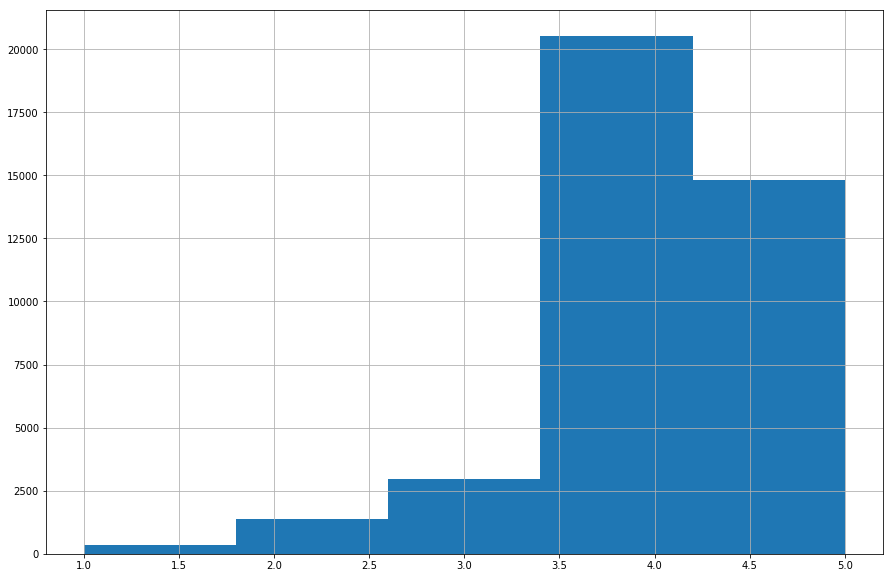

In [76]:
data[data['sample']==1]['Rating'].hist(bins=5)


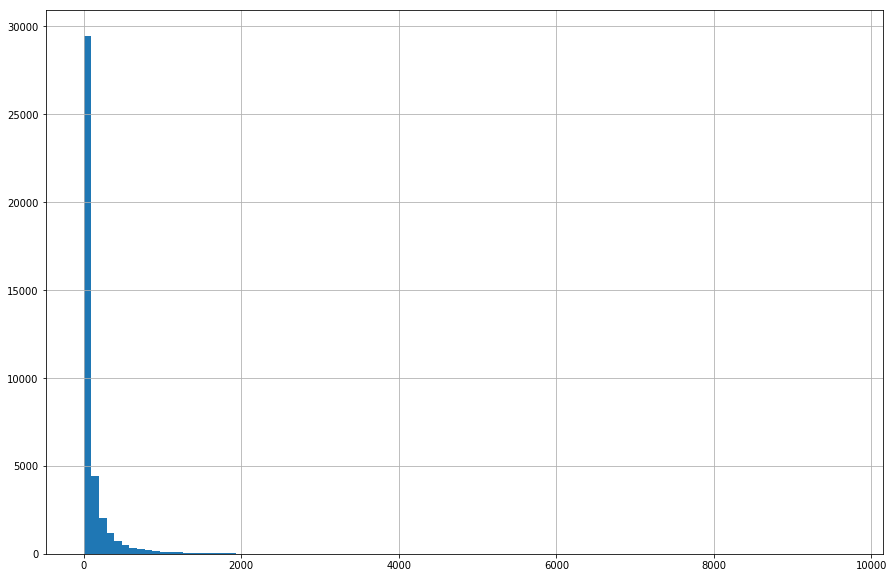

In [77]:
#data['Number_of_Reviews'] = data['Number_of_Reviews']**(1/3) #выгавнивание распределения ни как не сказывается 
data[data['sample']==1]['Number_of_Reviews'].hist(bins=100)

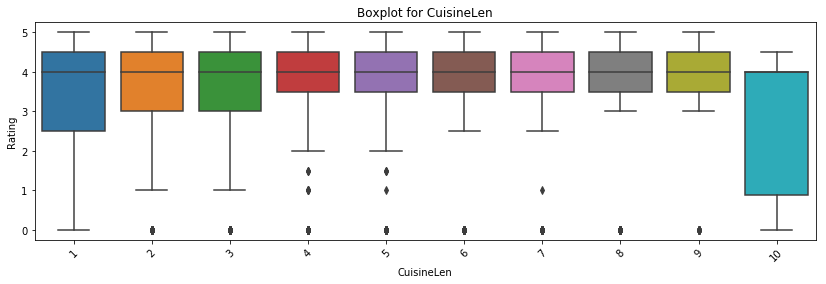

In [78]:
get_boxplot('CuisineLen','Rating') # в целом количество кухонь не сильно влияет на оценку однако 10 явно выбивается из общей картины

In [79]:
len(data[data['CuisineLen']==10]) # таких всего 26 попробуем удалить
#data = data.loc[data['CuisineLen']!=10] # модель ухудшилась

26

In [80]:
len(data[data['CuisineLen']==10])

26

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f34885b9080>,
      dtype=object)

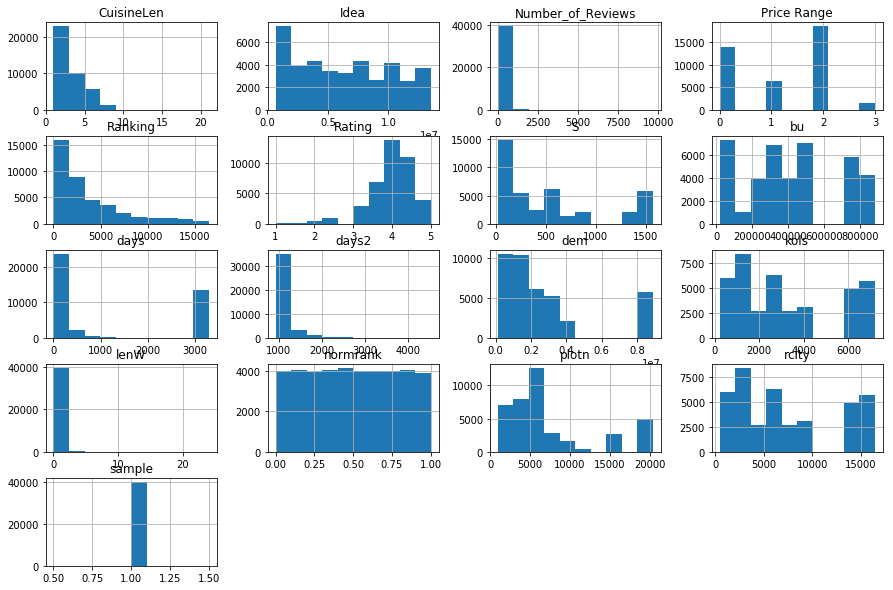

In [81]:
cdata[cdata['sample']==1].hist()


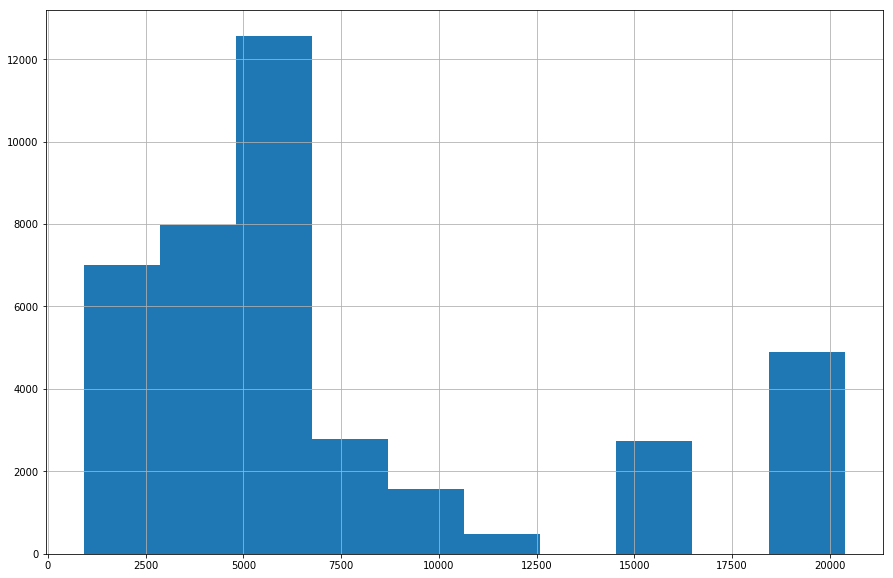

In [82]:
data[data['sample']==1]['plotn'].hist(bins=10)

In [83]:
#возможно значения больше 15000 выбросы. Попробуем удалить
#data = data.loc[data['plotn']<15000] #модель ухудшилась
 #mean = 4935.762228799952
#data['plotn'] = data['plotn'].apply(lambda x: x if x< 15000 else  4935.76) # модель ухудшилась
#data[data['sample']==1]['plotn'].hist(bins=10)

In [84]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA','kols'], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    
    # тут ваш код по обработке NAN
    # Для примера я возьму столбец Number of Reviews
    
    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [85]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Ranking,Price Range,Number_of_Reviews,sample,Rating,Number_of_Reviews_isNAN,rcity,normrank,CuisineLen,GlutenFreeOptions,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
20978,4453.0,2,84.0,1,4.0,0,13986.0,0.318390,3,0,...,0,0,1,0,0,0,0,0,0,0
1379,361.0,2,322.0,0,0.0,0,8809.0,0.040981,8,1,...,0,0,0,0,0,0,0,0,0,0
47533,2277.0,2,247.0,1,4.0,0,6275.0,0.362869,4,1,...,0,0,0,0,0,0,0,0,0,0
44883,12119.0,2,49.0,1,3.5,0,16444.0,0.736986,1,0,...,0,0,0,0,0,0,0,0,0,0
47302,2468.0,0,8.0,1,2.5,0,2666.0,0.925731,1,0,...,0,0,0,0,0,0,0,0,0,0
48947,1234.0,0,5.0,1,5.0,0,3444.0,0.358304,1,0,...,0,0,0,0,0,0,1,0,0,0
47634,890.0,0,9.0,1,4.5,0,2154.0,0.413185,1,0,...,0,0,0,0,0,0,0,1,0,0
32799,5202.0,2,45.0,1,3.5,0,8809.0,0.590532,4,0,...,0,0,0,0,0,0,0,0,0,0
45254,7036.0,0,14.0,1,4.5,0,13986.0,0.503075,1,0,...,0,0,1,0,0,0,0,0,0,0
38948,1577.0,1,36.0,1,4.0,0,3254.0,0.484634,2,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 177 entries, Ranking to City_nan
dtypes: float64(8), int64(136), uint8(33)
memory usage: 56.5 MB


In [87]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [88]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [89]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 176), (40000, 176), (40000, 175), (32000, 175), (8000, 175))

# Model 
Сам ML

In [90]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [91]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [92]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [93]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.19711312499999997


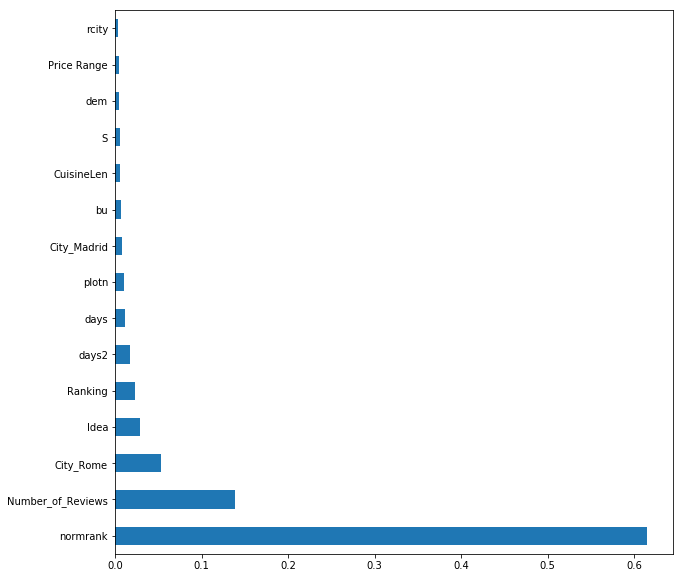

In [94]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [95]:
test_data.sample(10)

,Ranking,Price Range,Number_of_Reviews,Rating,Number_of_Reviews_isNAN,rcity,normrank,CuisineLen,GlutenFreeOptions,Dutch,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
4018,1303.0,2,129.0,0.0,0,8809.0,0.147917,3,0,0,...,0,0,0,0,0,0,0,0,0,0
8727,794.0,2,1543.0,0.0,0,6275.0,0.126534,6,0,0,...,0,0,0,0,0,0,0,0,0,0
2598,520.0,1,18.0,0.0,0,1141.0,0.455741,5,0,0,...,0,0,0,0,0,0,0,0,0,0
48,1077.0,0,3.0,0.0,0,1787.0,0.602686,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8409,2168.0,1,88.0,0.0,0,5948.0,0.364492,2,0,0,...,0,0,0,0,1,0,0,0,0,0
3123,2049.0,0,5.0,0.0,0,3444.0,0.594948,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2519,5316.0,0,5.0,0.0,0,7796.0,0.681888,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6380,2613.0,0,39.0,0.0,0,8809.0,0.296628,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3290,6682.0,0,3.0,0.0,0,13986.0,0.477763,2,0,0,...,0,0,1,0,0,0,0,0,0,0
3224,12816.0,0,4.0,0.0,0,16444.0,0.779372,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
test_data = test_data.drop(['Rating'], axis=1)

In [97]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [98]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [99]:
predict_submission

array([3.03 , 4.175, 4.165, ..., 3.01 , 4.465, 4.1  ])

In [100]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.030
1,id_1,4.175
2,id_2,4.165
3,id_3,4.320
4,id_4,4.455
5,id_5,4.475
6,id_6,1.820
7,id_7,3.315
8,id_8,4.105
9,id_9,4.635


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
